# Create zonal statistics and point extractions for comparing CONUS404 and reference datasets

<img src='./Eval_PreProc.svg' width=600>

The pre-processing step is needed in order to align the two datasets for analysis.  The specific 
steps needed to prepare a given dataset may differ, depending on the source and the variable of
interest. 

Some steps might include: 

* Organizing the time-series index such that the time steps for both simulated and observed are congruent
    * This may involve interpolation to estimate a more granular time-step than is found in the source data
    * More often, an agregating function is used to 'down-sample' the dataset to a coarser time step (days vs hours).
* Coordinate aggregation units between simulated and observed 
    * Gridded data may be sampled per HUC-12, HUC-6, etc. to match modeled data indexed by these units. 
    * Index formats may be adjusted (e.g. a 'gage_id' may be 'USGS-01104200' in one data set, vs '01104200' in another)
* Re-Chunking the data to make time-series analysis more efficient (see [here](/dev/null) for a primer on re-chunking).
<details>
  <summary>Guide to pre-requisites and learning outcomes...&lt;click to expand&gt;</summary>
  
  <table>
    <tr>
      <td>Pre-Requisites
      <td>To get the most out of this notebook, you should already have an understanding of these topics: 
        <ul>
        <li>pre-req one
        <li>pre-req two
        </ul>
    <tr>
      <td>Expected Results
      <td>At the end of this notebook, you should be able to: 
        <ul>
        <li>outcome one
        <li>outcome two
        </ul>
  </table>
</details>

In [26]:
# library imports
import fsspec #testing
import hvplot.xarray #testing
import intake #testing
import os #testing
import warnings #testing
import rioxarray #testing
import dask #testing
import metpy #testing
import calendar #testing
import sparse 
import cf_xarray

from shapely.geometry import Polygon #testing
from dask.distributed import LocalCluster, Client #testing
from pygeohydro import pygeohydro #testing
from fsspec.implementations.ftp import FTPFileSystem #testing
from holoviews.streams import PolyEdit, PolyDraw #testing
from geocube.api.core import make_geocube #testing

import xarray as xr #testing
import geopandas as gpd #testing
import pandas as pd #testing
import geoviews as gv #testing
import dask.dataframe as dd #testing
import numpy as np #testing

warnings.filterwarnings('ignore')
# prism_drb = xr.open_dataset(fs_read.open('s3://rsignellbucket2/hytest/tutorials/conus404_model_evaluation/prism_drb.nc'), chunks={})
# ceres_drb = xr.open_dataset(fs_read.open('s3://rsignellbucket2/hytest/tutorials/conus404_model_evaluation/ceres_drb.nc'), chunks={})

# Update to helper function after repo consolidation
## **Start a Dask client using an appropriate Dask Cluster** 
This is an optional step, but can speed up data loading significantly, especially when accessing data from the cloud.

In [2]:
def configure_cluster(machine):
    ''' Helper function to configure cluster
    '''
    if machine == 'denali':
        from dask.distributed import LocalCluster, Client
        cluster = LocalCluster(threads_per_worker=1)
        client = Client(cluster)
    
    elif machine == 'tallgrass':
        from dask.distributed import Client
        from dask_jobqueue import SLURMCluster
        cluster = SLURMCluster(queue='cpu', cores=1, interface='ib0',
                               job_extra=['--nodes=1', '--ntasks-per-node=1', '--cpus-per-task=1'],
                               memory='6GB')
        cluster.adapt(maximum_jobs=30)
        client = Client(cluster)
        
    elif machine == 'local':
        import os
        import warnings
        from dask.distributed import LocalCluster, Client
        warnings.warn("Running locally can result in costly data transfers!\n")
        n_cores = os.cpu_count() # set to match your machine
        cluster = LocalCluster(threads_per_worker=n_cores)
        client = Client(cluster)
        
    elif machine in ['esip-qhub-gateway-v0.4']:   
        import sys, os
        sys.path.append(os.path.join(os.environ['HOME'],'shared','users','lib'))
        import ebdpy as ebd
        aws_profile = 'nhgf-development'
        ebd.set_credentials(profile=aws_profile)

        aws_region = 'us-west-2'
        endpoint = f's3.{aws_region}.amazonaws.com'
        ebd.set_credentials(profile=aws_profile, region=aws_region, endpoint=endpoint)
        worker_max = 30
        client,cluster = ebd.start_dask_cluster(profile=aws_profile, worker_max=worker_max, 
                                              region=aws_region, use_existing_cluster=True,
                                              adaptive_scaling=False, wait_for_cluster=False, 
                                              worker_profile='Medium Worker', propagate_env=True)
        
    return client, cluster

### Setup your cluster

#### QHub...
Uncomment single commented spaces (#) to run

In [3]:
# set machine
machine = 'esip-qhub-gateway-v0.4'

# use configure cluster helper function to setup dask
client, cluster = configure_cluster(machine)

Region: us-west-2
No Cluster running.
Starting new cluster.
{}
Setting Cluster Environment Variable AWS_DEFAULT_REGION us-west-2
Setting Fixed Scaling workers=30
Reconnect client to clear cache
client.dashboard_link (for new browser tab/window or dashboard searchbar in Jupyterhub):
https://jupyter.qhub.esipfed.org/gateway/clusters/dev.87a4651d7d6f4fd3a7025eb425ee5350/status
Propagating environment variables to workers
Using environment: users/pangeo


#### or HPC
Uncomment single commented spaces (#) to run

In [ ]:
## set machine
# machine = os.environ['SLURM_CLUSTER_NAME']

## use configure_cluster helper function to setup dask
# client, cluster = configure_cluster(machine)

Dataset outline:
1. Read in the prepared dataset
2. Read in the HUC6 boundaries and transform to same coordinate reference system as prepared dataset
3. Make a data mask with the HUC6 boundaries to calculate zonal statistics
4. Compute zonal statistics with data mask and prepared data

Once all calculations are done: 

5. Combine each reference with benchmark into single dataset
6. Export gridded data zonal statistics
<br>

**CONUS404 zonal statistics**

## **Compute zonal statistics for gridded datasets**

In the last tutorial, we prepared three gridded datasets: CONUS404 (benchmark), PRISM (reference), and CERES-EBAF (reference). The goal of this section is compute [zonal statistics](https://gisgeography.com/zonal-statistics/) for each HUC6 zone in the Delaware River Basin (DRB) by using the [conservative regridding method put forth by Ryan Abernathy](https://discourse.pangeo.io/t/conservative-region-aggregation-with-xarray-geopandas-and-sparse/2715) to regrid and perform an area-weight analysis.

Dataset outline:
<ol>
    <li>Read in the prepared dataset</li>
    <li>Compute bounding bands for latitude and longitude (if necessary) then use these to create polygons in area-preserving CRS</li>
    <li>Read in the HUC6 boundaries and transform to same coordinate reference system as prepared dataset</li>
    <li>Overlay the dataset polygons over the HUC6 boundaries and create spatial weights matrices</li>
    <li>Perform matrix multiplication between The prepared dataset and the spatial weights matrices</li>
    <li>Perform zonal statistics</li>
</ol>

The following two functions will be used for regridding each dataset. Review them for now and an explanation of what they do will be provided when they are applied.

In [6]:
def bounds_to_poly(x_bounds, y_bounds):
    """Return a polygon based on the x (longitude) and y (longitude) bounding band DataArrays"""
    return Polygon([
        (x_bounds[0], y_bounds[0]),
        (x_bounds[0], y_bounds[1]),
        (x_bounds[1], y_bounds[1]),
        (x_bounds[1], y_bounds[0])
    ])

def apply_weights_matmul_sparse(weights, data):
    """Apply weights in a sparse matrices to data and regrid"""
    assert isinstance(weights, sparse.SparseArray)
    assert isinstance(data, np.ndarray)
    data = sparse.COO.from_numpy(data)
    data_shape = data.shape
    n, k = data_shape[0], data_shape[1] * data_shape[2]
    data = data.reshape((n, k))
    weights_shape = weights.shape
    k_, m = weights_shape[0] * weights_shape[1], weights_shape[2]
    assert k == k_
    weights_data = weights.reshape((k, m))

    regridded = sparse.matmul(data, weights_data)
    assert regridded.shape == (n, m)
    return regridded.todense()

And the following `fsspec.filesystem` will be using to read in each dataset from an [Open Storage Network](https://www.openstoragenetwork.org/) bucket, which is read only.

In [28]:
fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True,
                            client_kwargs={'endpoint_url': 'https://renc.osn.xsede.org'})

x = "x"
y = "y"

Setup the geometries for the DRB

<AxesSubplot: >

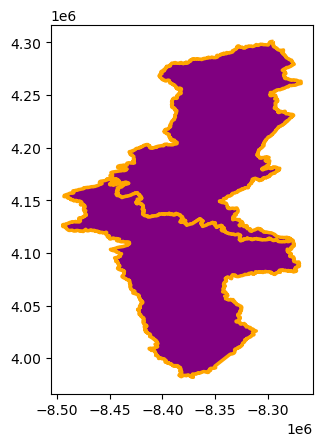

In [16]:
# bring in HUC6 boundaries found in the DRB
drb_gdf = pygeohydro.WBD("huc6", outfields=["huc6", "name"]).byids("huc6", ["020401", "020402"])

# area preserving crs
crs_area = "ESRI:53034"

# set CRS to match c404_drb
drb_gdf = drb_gdf.to_crs(crs_area)

#visualize
drb_gdf.plot(edgecolor="orange", facecolor="purple", linewidth=2.5)

**CONUS404 zonal statistics**

In [21]:
# c404_drb = xr.open_dataset(fs_read.open('s3://rsignellbucket2/hytest/tutorials/conus404_model_evaluation/c404_drb.nc'), chunks={})
# url to c404_drb
c404_drb_url = 's3://rsignellbucket2/hytest/tutorials/conus404_model_evaluation/c404_drb.nc'

# open dataset
c404_drb = xr.open_dataset(fs_read.open(c404_drb_url), decode_coords='all')

# crs
c404_crs = c404_drb.rio.crs.to_proj4()

# c404_drb

<xarray.Dataset>
Dimensions:      (time: 504, y: 105, x: 47)
Coordinates:
    crs          int32 ...
    lat          (y, x) float32 ...
    lon          (y, x) float32 ...
  * time         (time) datetime64[ns] 1979-10-31 1979-11-30 ... 2021-09-30
  * x            (x) float64 1.768e+06 1.772e+06 ... 1.948e+06 1.952e+06
  * y            (y) float64 2e+05 2.04e+05 2.08e+05 ... 6.12e+05 6.16e+05
Data variables:
    PREC_ACC_NC  (time, y, x) float32 ...
    RNET         (time, y, x) float32 ...
    TK           (time, y, x) float32 ...
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

Create the grid of c404_drb using any of the variables

In [31]:
# set vars
c404_var = "TK"

# drop unneeded variable and coordinates
c404_grid = c404_drb[[c404_var]].drop(['time', 'lon', 'lat', c404_var]).reset_coords()
c404_grid

<xarray.Dataset>
Dimensions:  (x: 47, y: 105)
Coordinates:
  * x        (x) float64 1.768e+06 1.772e+06 1.776e+06 ... 1.948e+06 1.952e+06
  * y        (y) float64 2e+05 2.04e+05 2.08e+05 ... 6.08e+05 6.12e+05 6.16e+05
Data variables:
    crs      int32 ...
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

And create bounding bands then stack into points

In [32]:
# add bounds
c404_grid = c404_grid.cf.add_bounds(x)
c404_grid = c404_grid.cf.add_bounds(y)

# stack
c404_points = c404_grid.stack(point=(y,x))
c404_points

<xarray.Dataset>
Dimensions:   (bounds: 2, point: 4935)
Coordinates:
    x_bounds  (bounds, point) float64 1.766e+06 1.77e+06 ... 1.95e+06 1.954e+06
    y_bounds  (bounds, point) float64 1.98e+05 1.98e+05 ... 6.18e+05 6.18e+05
  * point     (point) object MultiIndex
  * y         (point) float64 2e+05 2e+05 2e+05 ... 6.16e+05 6.16e+05 6.16e+05
  * x         (point) float64 1.768e+06 1.772e+06 ... 1.948e+06 1.952e+06
Dimensions without coordinates: bounds
Data variables:
    crs       int32 ...
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

2022-12-12 10:52:49,287 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


Next, use the `xarray apply_ufunc` function to apply the `bounds_to_poly` function above to the _c404_points_ DataSet.

In [33]:
c404_boxes = xr.apply_ufunc(
    bounds_to_poly,
    c404_points.x_bounds,
    c404_points.y_bounds,
    input_core_dims=[("bounds",),  ("bounds",)],
    output_dtypes=[np.dtype('O')],
    vectorize=True
)
c404_boxes

<xarray.DataArray (point: 4935)>
array([<shapely.geometry.polygon.Polygon object at 0x7fcaf2104760>,
       <shapely.geometry.polygon.Polygon object at 0x7fcaf2104640>,
       <shapely.geometry.polygon.Polygon object at 0x7fcaf2104a30>, ...,
       <shapely.geometry.polygon.Polygon object at 0x7fcaf1fde6a0>,
       <shapely.geometry.polygon.Polygon object at 0x7fcaf1fde6d0>,
       <shapely.geometry.polygon.Polygon object at 0x7fcaf1fde700>],
      dtype=object)
Coordinates:
  * point    (point) object MultiIndex
  * y        (point) float64 2e+05 2e+05 2e+05 ... 6.16e+05 6.16e+05 6.16e+05
  * x        (point) float64 1.768e+06 1.772e+06 ... 1.948e+06 1.952e+06

In [34]:
c404_grid_df= gpd.GeoDataFrame(
    data={"geometry": c404_boxes.values, "y": c404_boxes[y], "x": c404_boxes[x]},
    index=c404_boxes.indexes["point"],
    crs=c404_crs
)
c404_grid_df

geometry  \
y             x                                                                 
200039.100363 1.767902e+06  POLYGON ((1765902.099 198039.100, 1765902.099 ...   
              1.771902e+06  POLYGON ((1769902.099 198039.100, 1769902.099 ...   
              1.775902e+06  POLYGON ((1773902.099 198039.100, 1773902.099 ...   
              1.779902e+06  POLYGON ((1777902.099 198039.100, 1777902.099 ...   
              1.783902e+06  POLYGON ((1781902.099 198039.100, 1781902.099 ...   
...                                                                       ...   
616039.100363 1.935902e+06  POLYGON ((1933902.099 614039.100, 1933902.099 ...   
              1.939902e+06  POLYGON ((1937902.099 614039.100, 1937902.099 ...   
              1.943902e+06  POLYGON ((1941902.099 614039.100, 1941902.099 ...   
              1.947902e+06  POLYGON ((1945902.099 614039.100, 1945902.099 ...   
              1.951902e+06  POLYGON ((1949902.099 614039.100, 1949902.099 ...   

                                        y             x  
y             x                                          
200039.100363 1.767902e+06  200039.100363  1.767902e+06  
              1.771902e+06  200039.100363  1.771902e+06  
              1.775902e+06  200039.100363  1.775902e+06  
              1.779902e+06  200039.100363  1.779902e+06  
              1.783902e+06  200039.100363  1.783902e+06  
...                                   ...           ...  
616039.100363 1.935902e+06  616039.100363  1.935902e+06  
              1.939902e+06  616039.100363  1.939902e+06  
              1.943902e+06  616039.100363  1.943902e+06  
              1.947902e+06  616039.100363  1.947902e+06  
              1.951902e+06  616039.100363  1.951902e+06  

[4935 rows x 3 columns]

<AxesSubplot: >

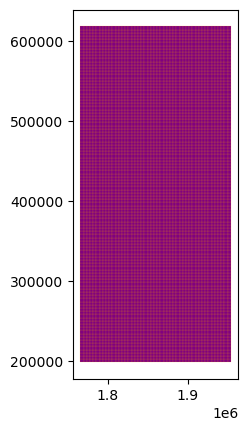

2022-12-12 11:26:42,330 - distributed.client - ERROR - Exception raised while shutting down cluster dev.87a4651d7d6f4fd3a7025eb425ee5350
Traceback (most recent call last):
  File "/home/conda/users/7d479acd42e90471353def6ca5a8af746b5fc7262141e86e2738676e7087dbc8-20221121-135211-565707-232-pangeo/lib/python3.9/site-packages/dask_gateway/client.py", line 993, in _stop_internal
    await self.gateway._stop_cluster(self.name)
  File "/home/conda/users/7d479acd42e90471353def6ca5a8af746b5fc7262141e86e2738676e7087dbc8-20221121-135211-565707-232-pangeo/lib/python3.9/site-packages/dask_gateway/client.py", line 654, in _stop_cluster
    await self._request("DELETE", url)
  File "/home/conda/users/7d479acd42e90471353def6ca5a8af746b5fc7262141e86e2738676e7087dbc8-20221121-135211-565707-232-pangeo/lib/python3.9/site-packages/dask_gateway/client.py", line 397, in _request
    resp = await session.request(method, url, json=json, **self._request_kwargs)
  File "/home/conda/users/7d479acd42e90471353def6

In [40]:
c404_grid_df.plot(edgecolor="orange", facecolor="purple", linewidth=0.1)

Overlay the two grids

In [ ]:
# convert DRB to conus404 crs
c404_drb_gdf
overlay = c404_grid_df.overlay(regions_df, keep_geom_type=True)
overlay

Read in HUC6 boundaries

<AxesSubplot: >

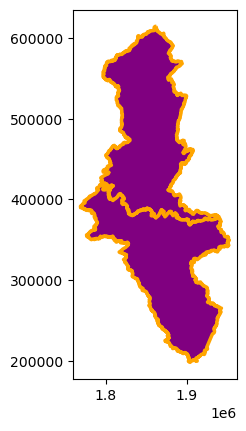

2022-12-06 12:01:12,358 - distributed.client - ERROR - Exception raised while shutting down cluster dev.9bf0da4839db47678c0620d9e56106b0
Traceback (most recent call last):
  File "/home/conda/users/7d479acd42e90471353def6ca5a8af746b5fc7262141e86e2738676e7087dbc8-20221121-135211-565707-232-pangeo/lib/python3.9/site-packages/dask_gateway/client.py", line 993, in _stop_internal
    await self.gateway._stop_cluster(self.name)
  File "/home/conda/users/7d479acd42e90471353def6ca5a8af746b5fc7262141e86e2738676e7087dbc8-20221121-135211-565707-232-pangeo/lib/python3.9/site-packages/dask_gateway/client.py", line 654, in _stop_cluster
    await self._request("DELETE", url)
  File "/home/conda/users/7d479acd42e90471353def6ca5a8af746b5fc7262141e86e2738676e7087dbc8-20221121-135211-565707-232-pangeo/lib/python3.9/site-packages/dask_gateway/client.py", line 397, in _request
    resp = await session.request(method, url, json=json, **self._request_kwargs)
  File "/home/conda/users/7d479acd42e90471353def6

In [7]:
# bring in HUC6 boundaries found in the DRB
drb_gdf = pygeohydro.WBD("huc6", outfields=["huc6", "name"]).byids("huc6", ["020401", "020402"])

# set CRS to match c404_drb
drb_gdf = drb_gdf.to_crs(c404_crs)

#visualize
drb_gdf.plot(edgecolor="orange", facecolor="purple", linewidth=2.5)

# **Testing geocube**

Create datamask and build new dataset

In [ ]:
# convert huc6 field to int as this works best for the following steps
drb_gdf["huc6"] = drb_gdf["huc6"].astype(int) #note: this may drop the # of digits from 6 to less depending on how many zeroes there were, may need to pad back to 6 digits later

In [ ]:
# c404_drb.rio.write_crs(c404_crs, inplace=True) 

# create an output grid
c404_out_grid = make_geocube(
    vector_data = drb_gdf,
    measurements=["huc6"],
    like=c404_drb
)

# add datarrays to grid
c404_out_grid["RNET"] = (c404_drb.RNET.dims, c404_drb.RNET.values, 
                         c404_drb.RNET.attrs, c404_drb.RNET.encoding)

c404_out_grid["TK"] = (c404_drb.TK.dims, c404_drb.TK.values,
                         c404_drb.TK.attrs, c404_drb.TK.encoding)

c404_out_grid["PREC_ACC_NC"] = (c404_drb.PREC_ACC_NC.dims, c404_drb.PREC_ACC_NC.values,
                         c404_drb.PREC_ACC_NC.attrs, c404_drb.PREC_ACC_NC.encoding)


Group data arrays by HUC6 code

In [ ]:
c404_grouped = c404_out_grid.drop_vars("spatial_ref").groupby(c404_out_grid.huc6)

Calculate the mean variables

In [ ]:
c404_grid_mean = c404_grouped.mean().rename({"RNET": "c404_RNET_mean", "TK": "c404_TK_mean", 
                                       "PREC_ACC_NC": "c404_PREC_ACC_NC_mean", "time":"time_index"})

Convert to a dataframe

In [ ]:
c404_zonal_stats = c404_grid_mean.to_dataframe().drop("spatial_ref", axis=1)
c404_zonal_stats.head(4)

The time has been replaced by the position index from the *c404_drb* time coordinate. Ungroup the data and add the time value from the index to the dataframe.

In [ ]:
c404_zonal_stats = c404_zonal_stats.reset_index(drop=False)

c404_zonal_stats["time"] = c404_drb.coords["time"][c404_zonal_stats["time_index"].values]

c404_zonal_stats.drop("time_index", axis=1, inplace=True)

c404_zonal_stats["time"] = c404_zonal_stats["time"].astype(str).str[:-3]

Reset huc6 back to a string type of length 6

In [ ]:
c404_zonal_stats["huc6"] = c404_zonal_stats["huc6"].astype(int).astype(str).str.zfill(6) # pads with 0's to make all column values lenght == 0
c404_zonal_stats

# **gdptools zonal stats - using generate weights method**

In [ ]:
%%time
from gdptools.helpers import generate_weights, build_subset, run_weights
from gdptools.ancillary import _get_cells_poly, _get_shp_bounds_w_buffer, _get_crs
from functools import reduce

gpd.options.use_pygeos=True

# get polygons of grid cells
c404_gridpoly = _get_cells_poly(c404_drb, x='x', y='y', var="RNET", crs_in=c404_crs)

# set index of zonal polygons
polygon_index = "huc6"
  
# generate weights for grid cells
c404_wght_n = generate_weights(
    poly=drb_gdf,
    poly_idx=polygon_index,
    grid_cells=c404_gridpoly,
    filename=None,
    wght_gen_crs=c404_crs,
)

# double check sum of weights
# print('sum of weights:', c404_wght_n.loc["20401"].wght.sum())


# run weights for each variable in the dataset
gdf_list = []

# for var in c404_drb.data_vars:
#     newgdf, vals = run_weights(
#             var=var,
#             t_name="time",
#             ds=c404_drb,
#             wght_file=c404_wght_n,
#             shp=drb_gdf,
#             geom_id=polygon_index,
#         )
#     # set values of variable
#     newgdf[var] = vals[0,:]
    
#     # reset index to allow later merge
#     newgdf.reset_index(inplace=True, drop=False)
    
#     # subset gdf
#     newgdf = newgdf[["huc6", var]]
    
#     #add gdf to list
#     gdf_list.append(newgdf)

# # use reduce function to combine dataframes
# c404_comb_gdf = reduce(lambda x, y: pd.merge(x, y, on = 'huc6'), gdf_list)

# c404_comb_gdf

# testing 

val_list = []

for var in c404_drb.data_vars:
    newgdf, vals = run_weights(
            var=var,
            t_name="time",
            ds=c404_drb,
            wght_file=c404_wght_n,
            shp=drb_gdf,
            geom_id=polygon_index,
        )
    
    #add gdf to list
    gdf_list.append(newgdf)
    
    #add val to list
    val_list.append(vals)

In [ ]:
from gdptools.helpers import finalize 

gdtools_c404_url = 's3://nhgf-development/workspace/tutorial/CONUS404/'

fs = fsspec.filesystem("s3", anon=False, requester_pays=True, skip_instance_cache=True)

gdptools_c404_mapper = fs.get_mapper(gdtools_c404_url)

sdate = str(c404_drb.coords["time"][0].values)[0:10]

var_dict = {
    var: {
        "long_name": c404_drb[var],
        "varname": var
    }
}

fres = finalize(
    gdf=gdf_list,
    vals=val_list,
    p_opath=gdptools_c404_mapper,
    prefix="c404_gdptools_zonal",
    start_date=sdate,
    time_interval=1,
    time_type="months",
    var_dict = var_dict
)

In [ ]:
gdf_list

# **gdptools zonal stats - Using calculate_weights method**

In [ ]:
# %%time
# metadata for calculating weights
from gdptools.helpers import calculate_weights
from gdptools.helpers import generate_weights, build_subset, run_weights
from gdptools.ancillary import _get_cells_poly, _get_shp_bounds_w_buffer, _get_crs
from functools import reduce

data_crs = c404_crs
x_coord = "x"
y_coord = "y"
t_coord = "time"
sdate = str(c404_drb.coords["time"][0].values)[0:10]
edate = str(c404_drb.coords["time"][-1].values)[0:10]
var = "RNET"
shp_crs = c404_crs
shp_poly_idx = "huc6"
wght_gen_crs = c404_crs

wghts, ds_ss = calculate_weights(
    data_file=c404_drb,
    data_crs=data_crs,
    x_coord=x_coord,
    y_coord=y_coord,
    t_coord=t_coord,
    sdate=sdate,
    edate=edate,
    var=var,
    shp_file=drb_gdf,
    shp_crs=shp_crs,
    shp_poly_idx=shp_poly_idx,
    wght_gen_file='gridmet_wghts.csv',
    wght_gen_crs=wght_gen_crs,
)

# newgdf, vals = run_weights(
#             var="RNET",
#             t_name="time",
#             ds=c404_drb,
#             wght_file=wghts,
#             shp=drb_gdf,
#             geom_id=polygon_index,
#         )

# run weights for each variable in the dataset
gdf_list = []

for var in ds_ss.data_vars:
    newgdf, vals = run_weights(
            var=var,
            t_name="time",
            ds=c404_drb,
            wght_file=wghts,
            shp=drb_gdf,
            geom_id=shp_poly_idx,
        )
    
    # transition dataframes
    vargdf = pd.DataFrame(data=vals, index=c404_drb.coords["time"].values, columns=newgdf.index.values).stack()
    vargdf = vargdf.reset_index(drop=False)
    
    var_col_name = "c404_" + var
    vargdf.rename({vargdf.columns[0]:"time", vargdf.columns[1]:"huc6", vargdf.columns[2]:var_col_name}, axis=1, inplace=True)
    
    # set values of variable
    # newgdf[var] = vals[i,0]

    # reset index to allow later merge
    # newgdf.reset_index(inplace=True, drop=False)

    # subset gdf
    # newgdf = newgdf[["huc6", var]]

    #add gdf to list
    gdf_list.append(vargdf)
    
# use reduce function to combine dataframes
c404_comb_gdf = reduce(lambda x, y: pd.merge(x, y, on = 'huc6'), gdf_list)

c404_comb_gdf

In [ ]:
test = pd.DataFrame(data=vals, index=c404_drb.coords["time"].values, columns=newgdf.index.values).stack()
test = test.reset_index(drop=False)
test.rename({test.columns[0]:"time", test.columns[1]:"huc6", test.columns[2]:"RNET"}, axis=1, inplace=True)

# **Conservative zonal stats**
Method by Ryan Abernathy

In [ ]:
# url to c404_drb
c404_drb_url = 's3://nhgf-development/workspace/tutorial/CONUS404/c404_drb.nc'

fs = fsspec.filesystem("s3", anon=False, requester_pays=True, skip_instance_cache=True)

# open dataset
c404_drb = xr.open_dataset(fs.open(c404_drb_url), decode_coords="all")

# set crs
c404_crs = c404_drb.rio.crs.to_proj4()

# c404_drb

In [ ]:
#create lon_bounds and lat_bounds
spat_res = 4000.
x_vals = c404_drb.coords["x"].values
y_vals = c404_drb.coords["y"].values

new_lon_bounds = np.stack((x_vals, x_vals + spat_res), axis=-1)
new_lat_bounds = np.stack((y_vals, y_vals + spat_res), axis=-1)

# create data arrays 
lon_bounds = xr.DataArray(
    data=new_lon_bounds,
    dims=("x", "nv"),
    coords=dict(
        lat=("x")
    )
)

lat_bounds = xr.DataArray(
    data=new_lat_bounds,
    dims=("y", "nv"),
    coords=dict(
        lat=("y")
    )
)

# assign to dataset
c404_drb = c404_drb.assign_coords({
    "lon_bounds": lon_bounds,
    "lat_bounds": lat_bounds
})

In [ ]:
# function to create bolygons
def bounds_to_poly(lon_bounds, lat_bounds):
    if lon_bounds[0] >= 180:
        # geopandas needs this
        lon_bounds = lon_bounds - 360
    return Polygon([
        (lon_bounds[0], lat_bounds[0]),
        (lon_bounds[0], lat_bounds[1]),
        (lon_bounds[1], lat_bounds[1]),
        (lon_bounds[1], lat_bounds[0])
    ])

In [ ]:
# bring in HUC6 boundaries found in the DRB
drb_gdf = pygeohydro.WBD("huc6", outfields=["huc6", "name"]).byids("huc6", ["020401", "020402"])

crs_orig = "EPSG:4326"

# set CRS to albers equal conic area
drb_gdf = drb_gdf.to_crs(c404_crs)

#extract grid information
grid = c404_drb.drop(["time", "lon", "lat", "crs"]).reset_coords(["lon_bounds", "lat_bounds"])

# #stack into 1D array
points = grid.stack(point=("y", "x"))

# apply bonds to poly
boxes = xr.apply_ufunc(
    bounds_to_poly,
    points.lon_bounds,
    points.lat_bounds,
    input_core_dims=[("nv",),  ("nv",)],
    output_dtypes=[np.dtype('O')],
    vectorize=True
)

grid_df= gpd.GeoDataFrame(
    data={"geometry": boxes.values, "latitude": boxes.y, "longitude": boxes.x},
    index=boxes.indexes["point"],
    crs=c404_crs
)
# grid_df.plot()

Overlay geos and calculate weights

In [ ]:
# overlay geos
overlay = grid_df.overlay(drb_gdf)
# overlay

grid_cell_fraction = overlay.geometry.area.groupby(overlay.huc6).transform(lambda x: x / x.sum())
# grid_cell_fraction

# turn into sparse array
multi_index = overlay.set_index(["latitude", "longitude", "huc6"]).index
df_weights = pd.DataFrame({"weights": grid_cell_fraction.values}, index=multi_index)
# df_weights

ds_weights = xr.Dataset(df_weights)
# ds_weights

weights_sparse = ds_weights.unstack(sparse=True, fill_value=0.).weights
weights_sparse

In [ ]:
import sparse
# function to multiply matrices
def apply_weights_matmul_sparse(weights, data):

    assert isinstance(weights, sparse.SparseArray)
    assert isinstance(data, np.ndarray)
    data = sparse.COO.from_numpy(data)
    data_shape = data.shape
    # k = nlat * nlon
    n, k = data_shape[0], data_shape[1] * data_shape[2]
    data = data.reshape((n, k))
    weights_shape = weights.shape
    k_, m = weights_shape[0] * weights_shape[1], weights_shape[2]
    assert k == k_
    weights_data = weights.reshape((k, m))

    regridded = sparse.matmul(data, weights_data)
    assert regridded.shape == (n, m)
    return regridded.todense()

# The code below results in an empty matrices

In [ ]:
# testing with RNET
rnet_in_mem = c404_drb.RNET.compute().chunk({"time":"5MB"})
rnet_in_mem = rnet_in_mem.drop(["lon", "lat", "crs"])

# perform regridding 
rnet_regridded = xr.apply_ufunc(
    apply_weights_matmul_sparse,
    weights_sparse,
    rnet_in_mem,
    join="left",
    input_core_dims=[list(weights_sparse.dims), list(rnet_in_mem.dims)[1:]],
    output_core_dims=[["huc6"]],
    dask="parallelized",
    meta=[np.ndarray((0,))]
)
rnet_regridded

In [ ]:
rnet_regridded.load()

In [ ]:
rnet_regridded.sel(huc6="020401").resample(time="MS").mean().plot()

**PRISM zonal statistics**

PRISM has two variables: TK and PREC_ACC_NC

In [ ]:
# url to prism_drb
prism_drb_url = 's3://nhgf-development/workspace/tutorial/CONUS404/prism_drb.nc'

fs = fsspec.filesystem("s3", anon=False, requester_pays=True, skip_instance_cache=True)

# open dataset
prism_drb = xr.open_dataset(fs.open(prism_drb_url), decode_coords="all")

# create an output grid
prism_out_grid = make_geocube(
    vector_data = drb_gdf,
    measurements=["huc6"],
    like=prism_drb
)

# add datarrays to grid
prism_out_grid["TK"] = (prism_drb.TK.dims, prism_drb.TK.values,
                         prism_drb.TK.attrs, prism_drb.TK.encoding)

prism_out_grid["PREC_ACC_NC"] = (prism_drb.PREC_ACC_NC.dims, prism_drb.PREC_ACC_NC.values,
                         prism_drb.PREC_ACC_NC.attrs, prism_drb.PREC_ACC_NC.encoding)

# groupby
prism_grouped = prism_out_grid.drop_vars("spatial_ref").groupby(prism_out_grid.huc6)

# Calculate the mean variables
prism_grid_mean = prism_grouped.mean().rename({"TK": "prism_TK_mean", 
                                       "PREC_ACC_NC": "prism_PREC_ACC_NC_mean", "time":"time_index"})

#convert to a dataframe
prism_zonal_stats = prism_grid_mean.to_dataframe().drop("spatial_ref", axis=1)

# reste index and add time back
prism_zonal_stats = prism_zonal_stats.reset_index(drop=False)
prism_zonal_stats["time"] = prism_drb.coords["time"][prism_zonal_stats["time_index"].values]
prism_zonal_stats.drop("time_index", axis=1, inplace=True)
prism_zonal_stats["time"] = prism_zonal_stats["time"].astype(str).str[:-3]

# change huc6 to string and pad with zeros
prism_zonal_stats["huc6"] = prism_zonal_stats["huc6"].astype(int).astype(str).str.zfill(6) # pads with 0's to make all column values lenght == 0

prism_zonal_stats

Merge the PRISM and CONUS404 zonals stats together based on the HUC6 code and time

In [ ]:
prism_c404_zonal = prism_zonal_stats.merge(c404_zonal_stats, left_on=['huc6', 'time'], right_on=['huc6', 'time'])
prism_c404_zonal.head()

We don't need the CONUS404 RNET value so we'll drop that column before exporting the data

In [ ]:
prism_c404_zonal.drop("c404_RNET_mean", axis=1, inplace=True)

Export the data

In [ ]:
prism_c404_zonal.to_parquet("s3://nhgf-development/workspace/tutorial/CONUS404/prism_c404_zonal.parquet")

**CERES-EBAF zonal statistics**

CERES-EBAF has a single variable: RNET

In [ ]:
# url to ceres_drb
ceres_drb_url = 's3://nhgf-development/workspace/tutorial/CONUS404/ceres_drb.nc'

fs = fsspec.filesystem("s3", anon=False, requester_pays=True, skip_instance_cache=True)

# open dataset
ceres_drb = xr.open_dataset(fs.open(ceres_drb_url), decode_coords="all", chunks={"time":10})
    
# create an output grid
ceres_out_grid = make_geocube(
    vector_data = drb_gdf,
    measurements=["huc6"],
    like=ceres_drb
)

# add datarrays to grid
ceres_out_grid["RNET"] = (ceres_drb.RNET.dims, ceres_drb.RNET.values,
                         ceres_drb.RNET.attrs, ceres_drb.RNET.encoding)

# groupby
ceres_grouped = ceres_out_grid.drop_vars("spatial_ref").groupby(ceres_out_grid.huc6)

# Calculate the mean variables
ceres_grid_mean = ceres_grouped.mean().rename({"RNET": "ceres_RNET_mean", "time":"time_index"})

#convert to a dataframe
ceres_zonal_stats = ceres_grid_mean.to_dataframe().drop("spatial_ref", axis=1)

# reste index and add time back
ceres_zonal_stats = ceres_zonal_stats.reset_index(drop=False)
ceres_zonal_stats["time"] = ceres_drb.coords["time"][ceres_zonal_stats["time_index"].values]
ceres_zonal_stats.drop("time_index", axis=1, inplace=True)
ceres_zonal_stats["time"] = ceres_zonal_stats["time"].astype(str).str[:-3]

# change huc6 to string and pad with zeros
ceres_zonal_stats["huc6"] = ceres_zonal_stats["huc6"].astype(int).astype(str).str.zfill(6) # pads with 0's to make all column values lenght == 0

ceres_zonal_stats

Merge the CERES-EBAF and CONUS404 zonals stats together based on the HUC6 code and time

In [ ]:
ceres_c404_zonal = ceres_zonal_stats.merge(c404_zonal_stats, left_on=['huc6', 'time'], right_on=['huc6', 'time'])
ceres_c404_zonal.head()

We don't need the CONUS404 TK and PREC_ACC_NC values so we'll drop these columns before exporting the data

In [ ]:
ceres_c404_zonal.drop(["c404_TK_mean", "c404_PREC_ACC_NC_mean"], axis=1, inplace=True)

In [ ]:
ceres_c404_zonal

Export the data

In [ ]:
ceres_c404_zonal.to_parquet("s3://nhgf-development/workspace/tutorial/CONUS404/ceres_c404_zonal.parquet")

## **Extract gridded values to points**

The goal of this section is extract values from CONUS404 where they intersect with station data. This process is described in article about the ESRI tool [Extract Values to Points](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/extract-values-to-points.htm). This tabular data will then be exported for use in the next notebook, **CONUS404 Analysis**.

Dataset outline:
1. Read in the prepared dataset
2. Extract data from overlapping pixel at same time step as point
<br>

**Climate Reference Network point extraction**

In [ ]:
fs = fsspec.filesystem("s3", anon=False, requester_pays=True, skip_instance_cache=True)

crn_drb_df = pd.read_parquet(fs.open("s3://nhgf-development/workspace/tutorial/CONUS404/crn_drb.parquet"))

# create geodataframe
crn_drb = gpd.GeoDataFrame(crn_drb_df, crs=4326,
                       geometry=gpd.points_from_xy(crn_drb_df.LONGITUDE, 
                                                         crn_drb_df.LATITUDE))

# modify date field
crn_drb["DATE"] = crn_drb["DATE"].astype(str).str[:-3]

crn_drb.rename({"DATE": "time",
                "TK": "crn_TK", 
                "RNET": "crn_RNET", 
                "PREC_ACC_NC": "crn_PREC_ACC_NC"},
                  axis=1, inplace=True)

crn_drb.head()

Get coordinates from crn_drb to index c404_drb by

In [ ]:
# isolate single row and transform to c404_drb crs
crn_coords_gdf = crn_drb.iloc[[0]].to_crs(c404_crs)

# extract lat/long values
crn_lat = crn_coords_gdf.iloc[0]["geometry"].y
crn_lon = crn_coords_gdf.iloc[0]["geometry"].x

# time
crn_time_min = crn_drb_df["time"].min()
crn_time_max = crn_drb_df["time"].max()
crn_time_min, crn_time_max

# subset c404_drb to lat/long using nearest
c404_crn_sub = c404_drb.sel(x=crn_lon, y=crn_lat, method="nearest")

# slice to time-steps of crn_drb
c404_crn_sub = c404_crn_sub.sel(time=slice(crn_time_min, crn_time_max))

c404_crn_sub

Convert subset to dataframe and reorganize columns

In [ ]:
c404_sub_crn_df = c404_crn_sub.to_dataframe().reset_index(drop=False)

# trim columns
c404_sub_crn_df = c404_sub_crn_df[["time", "TK", "RNET", "PREC_ACC_NC"]]

# rename columns
c404_sub_crn_df.rename({"TK": "c404_TK", 
                    "RNET": "c404_RNET", 
                    "PREC_ACC_NC": "c404_PREC_ACC_NC"},
                  axis=1, inplace=True)

# trim time
c404_sub_crn_df["time"] = c404_sub_crn_df["time"].astype(str).str[:-3]

c404_sub_crn_df

Combine CONUS404 subset with CRN data

In [ ]:
crn_c404_point = crn_drb.merge(c404_sub_crn_df, on="time").reset_index(drop=False)

# drop columns
crn_c404_point.drop(["index", "LATITUDE", "LONGITUDE", "ID", "geometry"], axis=1, inplace=True)

crn_c404_point.head()

Export dataset

In [ ]:
crn_c404_point.to_parquet("s3://nhgf-development/workspace/tutorial/CONUS404/crn_c404_point.parquet")

**Historical Climate Network (HCN) point extraction**

The HCN data is different than the CRN data as the HCN data comes from multiple stations whereas the CRN data was from a single station. This will involve using multiple sets of geographic coordinates to extract data from CONUS404.

In [ ]:
# read in the HCN dataset
fs = fsspec.filesystem("s3", anon=False, requester_pays=True, skip_instance_cache=True)

hcn_drb_df = pd.read_parquet(fs.open("s3://nhgf-development/workspace/tutorial/CONUS404/hcn_drb.parquet"))

#rename columns
hcn_drb_df.rename({"DATE": "time",
                "TK": "hcn_TK",  
                "PREC_ACC_NC": "hcn_PREC_ACC_NC"},
                  axis=1, inplace=True)

# change DATE field to 
hcn_drb_df["time"] = hcn_drb_df["time"].astype(str).str[:-3]

hcn_drb_df.head()

Get a DataFrame of the station IDs, lats, and longs to use for extract data

In [ ]:
hcn_stations = hcn_drb_df.copy().drop(["time", "hcn_TK", "hcn_PREC_ACC_NC"], axis=1)
hcn_stations["LONGITUDE"] = pd.to_numeric(hcn_stations["LONGITUDE"])
hcn_stations["LATITUDE"] = pd.to_numeric(hcn_stations["LATITUDE"])

hcn_stations = hcn_stations.groupby('ID').mean().reset_index(drop=False)
# hcn_stations

Create a GeoDataFrame to convert the lat and long to the coordinate system of CONUS404

In [ ]:
hcn_stations_gdf = gpd.GeoDataFrame(hcn_stations, crs=4326,
                       geometry=gpd.points_from_xy(hcn_stations.LONGITUDE, 
                                                         hcn_stations.LATITUDE))

# transform to c404_drb crs
hcn_stations_gdf = hcn_stations_gdf.to_crs(c404_crs)

# extract lat/long values
hcn_stations_gdf["y"] = hcn_stations_gdf["geometry"].y
hcn_stations_gdf["x"] = hcn_stations_gdf["geometry"].x

#drop lat/lon/geo
hcn_stations_df = hcn_stations_gdf.drop(["LATITUDE", "LONGITUDE", "geometry"], axis=1)

Subset c404_drb to time period of HCN

In [ ]:
# time min/max
hcn_time_min = hcn_drb_df["time"].min()
hcn_time_max = hcn_drb_df["time"].max()

# slice c404 to HCN time
c404_hcn_timesub = c404_drb.sel(time=slice(hcn_time_min, hcn_time_max))

Use Dataframe rows to extract data from c404_drb

In [ ]:
# list of extracted data
c404_hcn_subs = []

for index, data in hcn_stations_df.iterrows():
    c404_hcn_sub_step = c404_hcn_timesub.sel(x=data.x, y=data.y, method="nearest").to_dataframe()
    c404_hcn_sub_step["ID"] = data.ID
    c404_hcn_subs.append(c404_hcn_sub_step)

# concat list of extracted data into single Dataframe
c404_hcn_sub = pd.concat(c404_hcn_subs)

#reset index
c404_hcn_sub.reset_index(drop=False, inplace=True)

# drop columns
c404_hcn_sub.drop(["RNET", "lon", "lat", "y", "x", "crs"], axis=1, inplace=True)

# rename columns
c404_hcn_sub.rename({"TK":"c404_TK",
                    "PREC_ACC_NC": "c404_PREC_ACC_NC"},
                   axis=1, inplace=True)

# trim time
c404_hcn_sub["time"] = c404_hcn_sub["time"].astype(str).str[:-3]

# c404_hcn_sub

Merge CONUS404 observations to HCH observations using the station ID and time

In [ ]:
hcn_c404_point = hcn_drb_df.merge(c404_hcn_sub, left_on=["ID", "time"], right_on=["ID", "time"])

# drop columns
hcn_c404_point.drop(["LATITUDE", "LONGITUDE"], axis=1, inplace=True)

hcn_c404_point.head()

Export the dataset

In [ ]:
hcn_c404_point.to_parquet("s3://nhgf-development/workspace/tutorial/CONUS404/hcn_c404_point.parquet")

Check all of the files that have been created in the data preparation notebooks

In [ ]:
fs = fsspec.filesystem("s3", anon=False, requester_pays=True, skip_instance_cache=True)

fs.ls("s3://nhgf-development/workspace/tutorial/CONUS404")

Shut down the client and cluster

In [ ]:
client.close(); cluster.shutdown()

# Next: CONUS404 Analysis notebook

Now that we have moved through our data preparation and calculated zonal and point statistics, we can move on to analyzing the differences between CONUS404 and the reference data in the CONUS404 Analysis notebook.

In [ ]:
# # Last code cell of the notebook
# import watermark.watermark as watermark
# print(watermark(iversions=True, python=True, machine=True, globals_=globals()))